In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Recargar el archivo
file_path = "housing.csv"
df = pd.read_csv(file_path)

target = 'median_house_value'


### Crea una regresión lineal con cross validation

In [2]:
# Dummies y NAS
df=pd.get_dummies(df)
df['total_bedrooms']=df['total_bedrooms'].fillna(df.total_bedrooms.mean())

In [3]:
# Define X, y
X=df.copy()
X = X.drop(target, axis=1)
y = df[target]
# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
# Entrenar modelo con interacciones
model=linear_model.LinearRegression().fit(X_train, y_train)
# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_lineal = model.predict(X_test)
r2_score(y_pred=predicciones_lineal, y_true=y_test)


0.6395785380523742

In [4]:
## Crea una función de  calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y':y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()
    
    plt.plot(grouped.predicciones, grouped.y, label='Modelo', marker = 'o')
    plt.plot(grouped.predicciones, grouped.predicciones, label='Real', marker = 'o')
    plt.grid()
    plt.legend()
    plt.xlabel('Prediccion')
    plt.ylabel('Real')

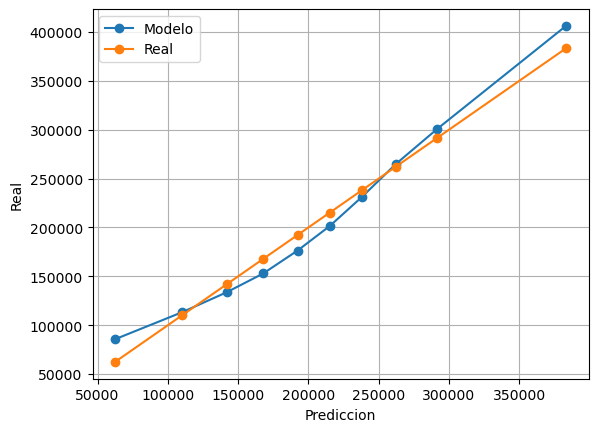

In [5]:
calibracion(predicciones_lineal, y_test, 10)

### Standard escaler

Escalar valor a media 0 y varianza 1


$Z = \frac{x - \mu}{\sigma}$


In [6]:
X_prueba = df[['total_rooms', 'median_income']]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_prueba)
X_prueba_escalada = scaler.transform(X_prueba)

X_prueba.head()

,total_rooms,median_income
0,880.0,8.3252
1,7099.0,8.3014
2,1467.0,7.2574
3,1274.0,5.6431
4,1627.0,3.8462


In [7]:
X_prueba_escalada

array([[-0.8048191 ,  2.34476576],
       [ 2.0458901 ,  2.33223796],
       [-0.53574589,  1.7826994 ],
       ...,
       [-0.17499526, -1.14259331],
       [-0.35559977, -1.05458292],
       [ 0.06840827, -0.78012947]])

### Polinomio grado 2 y escalamiento

In [8]:

degree = 2

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.3, random_state=42)

# Ridge o Lasso
model=linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly2 = model.predict(X_test)
r2_score(y_pred = predicciones_poly2, y_true=y_test)

0.6855523416341052

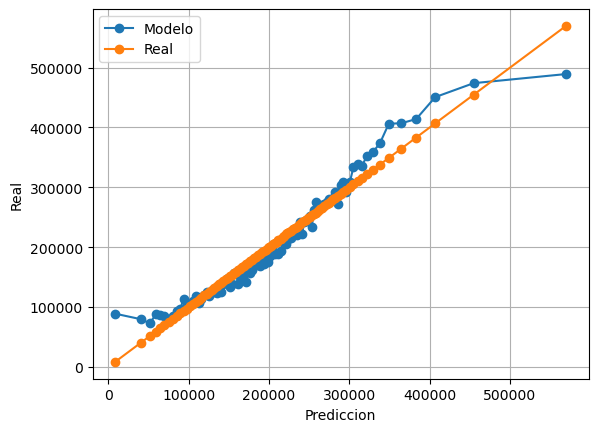

In [9]:
calibracion(predicciones_lineal, y_test, 100)

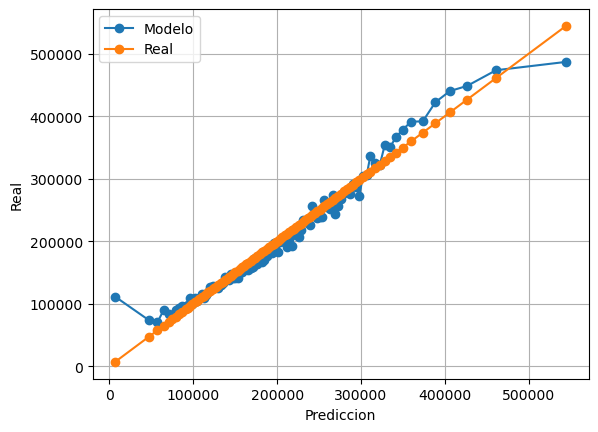

In [10]:
calibracion(predicciones_poly2, y_test, 100)

#### Polinomio grado 3

In [11]:

degree = 3

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.3, random_state=42)

# Ridge o Lasso
model=linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly3 = model.predict(X_test)
r2_score(y_pred = predicciones_poly3, y_true=y_test)


0.7262781624521402

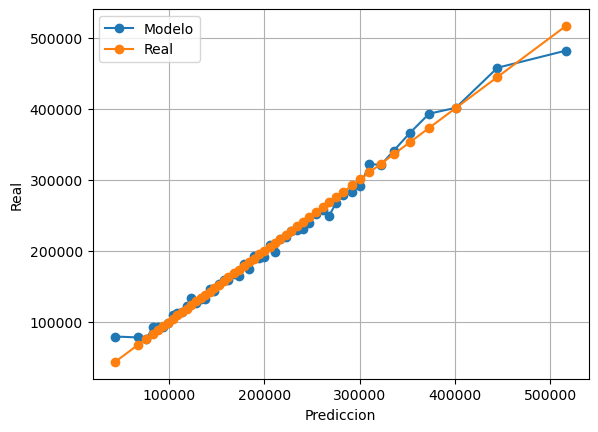

In [12]:
calibracion(predicciones_poly3, y_test, bins=50)

### Feature engenieering 

Per room
* Population per room
* Bedrooms per room

Per household
* Population per household
* Rooms per household
* Bedrooms per household

Per population
* Income per person
* Rooms per person

Transformaciones
* Logaritmo ingreso
* Raíz de total rooms 
* Median income **2 

In [13]:
# Per room
# * Population per room
# * Bedrooms per room

df['population_per_room']= df['population']/df['total_rooms']
df['bedrooms_per_rooms']= df['total_bedrooms']/df['total_rooms']

#Per household
#* Population per household
#* Rooms per household
#* Bedrooms per household

df['population_per_household']=df['population'] / df['households']
df['total_rooms_per_household']=df['total_rooms'] / df['households']
df['bedrooms_per_household']=df['total_bedrooms'] / df['households']

#Per population
#* Income per person
#* Rooms per person

df['median_income_per_person']=df['median_income'] / df['population']
df['total_rooms_per_person']=df['total_rooms'] / df['population']

#Transformaciones
#* Logaritmo ingreso
#* Raíz de total rooms 
#* Median income **2 

df['log_income']= np.log(df['median_income'])
df['sqrt_total_rooms']= np.sqrt(df['total_rooms'])
df['median_income_2']= df['median_income']**2

In [14]:
# Correlación 
df.corr()['median_house_value']

longitude                    -0.045967
latitude                     -0.144160
housing_median_age            0.105623
total_rooms                   0.134153
total_bedrooms                0.049454
population                   -0.024650
households                    0.065843
median_income                 0.688075
median_house_value            1.000000
ocean_proximity_<1H OCEAN     0.256617
ocean_proximity_INLAND       -0.484859
ocean_proximity_ISLAND        0.023416
ocean_proximity_NEAR BAY      0.160284
ocean_proximity_NEAR OCEAN    0.141862
population_per_room          -0.033557
bedrooms_per_rooms           -0.220049
population_per_household     -0.023737
total_rooms_per_household     0.151948
bedrooms_per_household       -0.044265
median_income_per_person      0.114455
total_rooms_per_person        0.209482
log_income                    0.651807
sqrt_total_rooms              0.161365
median_income_2               0.624514
Name: median_house_value, dtype: float64

In [15]:
# Define los valores numericos
numerical_features=[i for i in df.keys() if 'ocean_proximity' not in i and i != 'median_house_value' ]

### Realiza un bivariado de las variables numericas

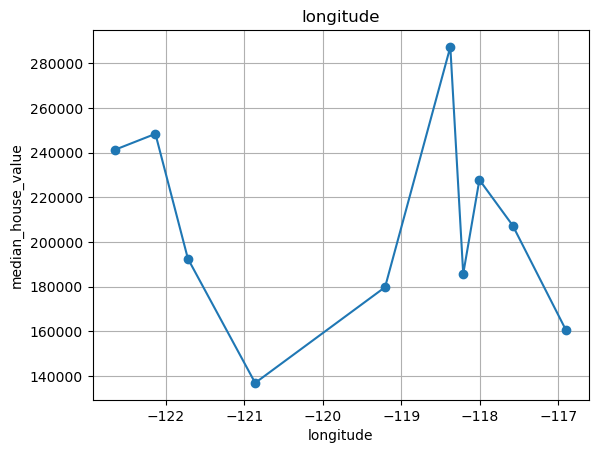

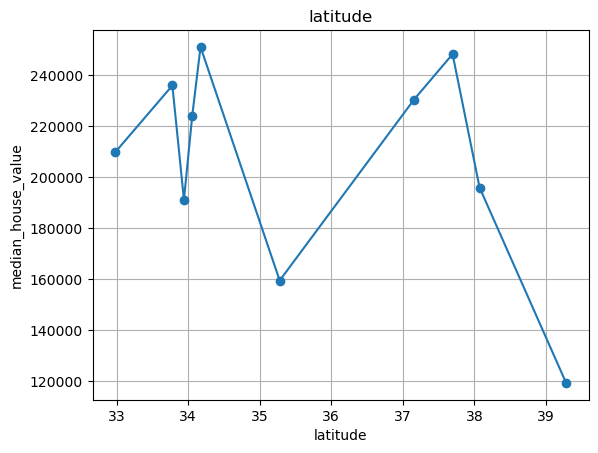

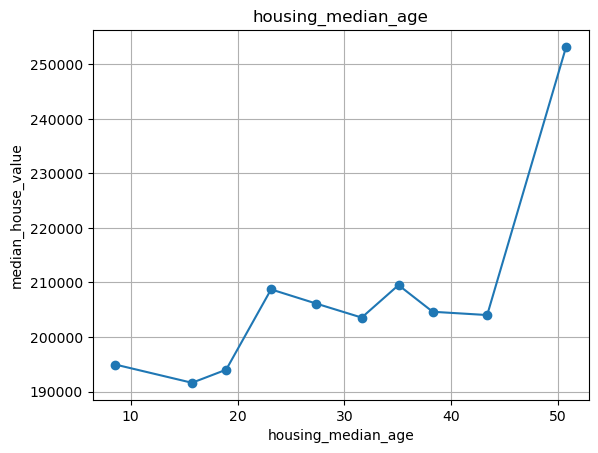

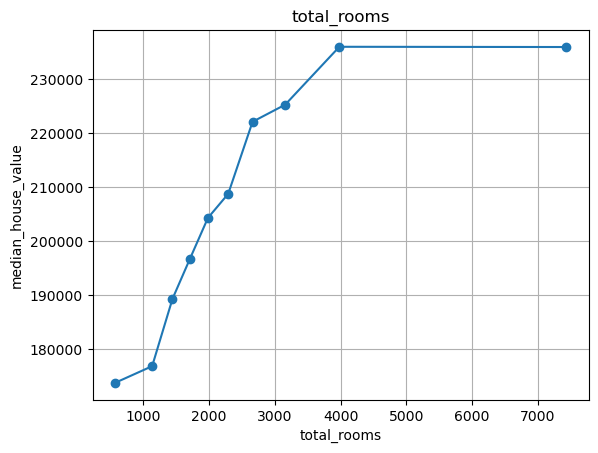

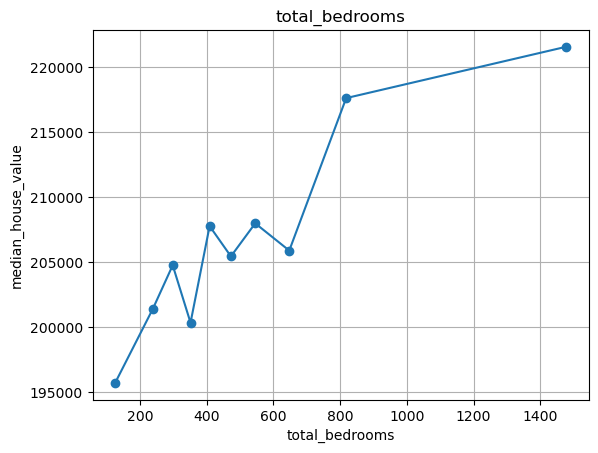

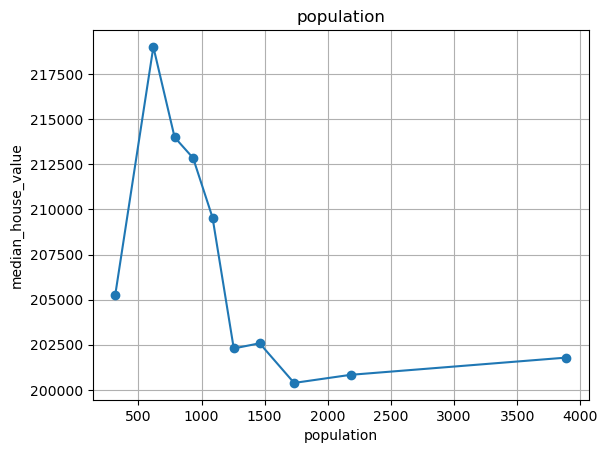

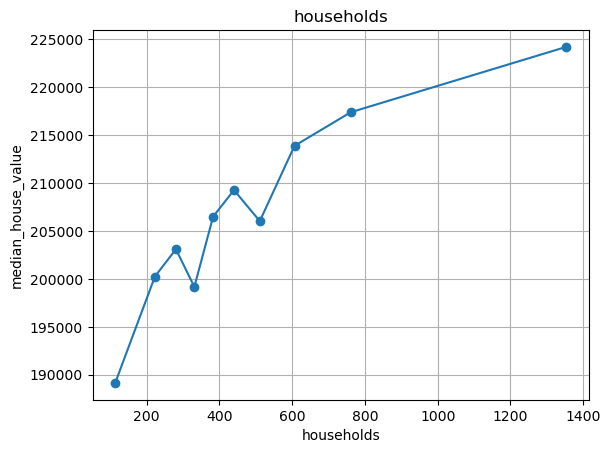

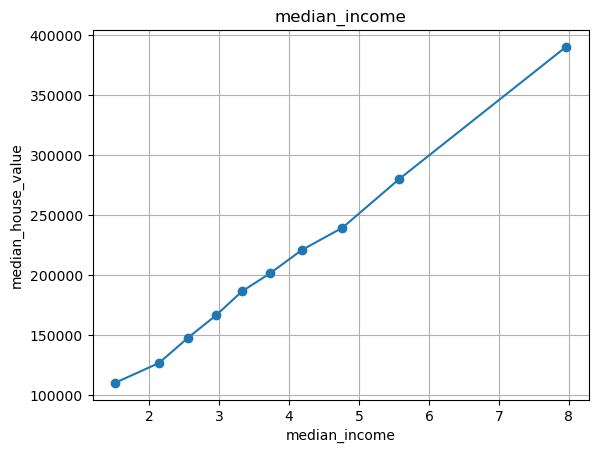

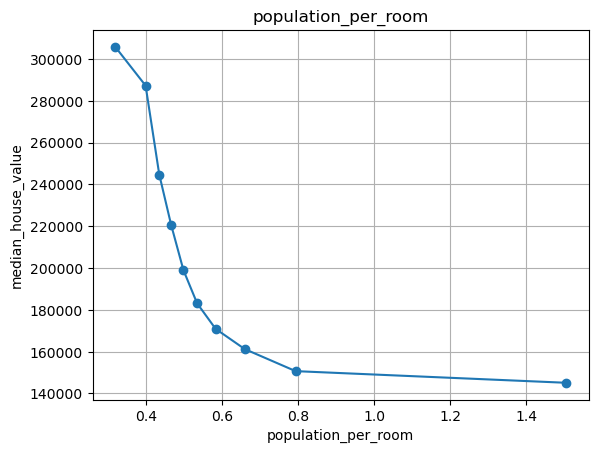

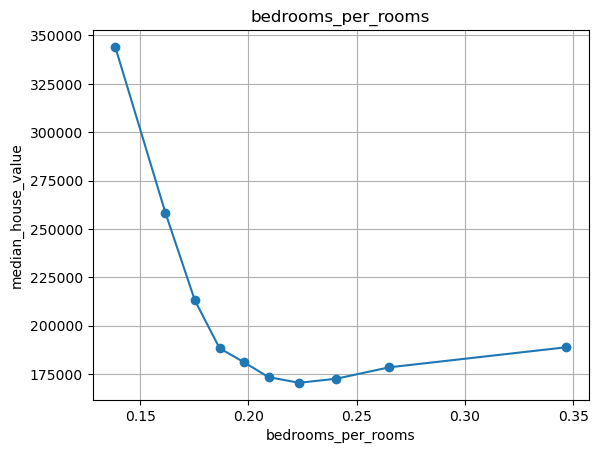

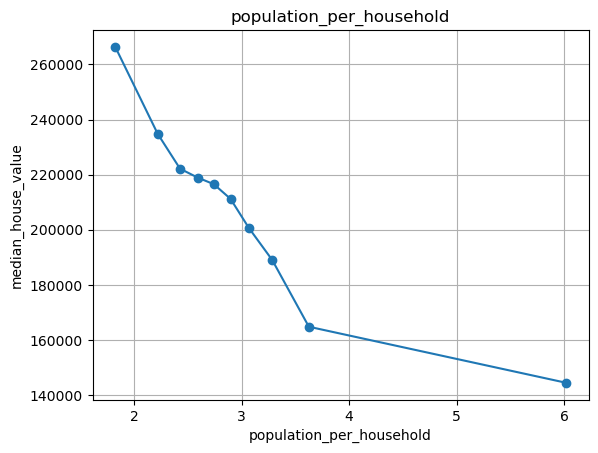

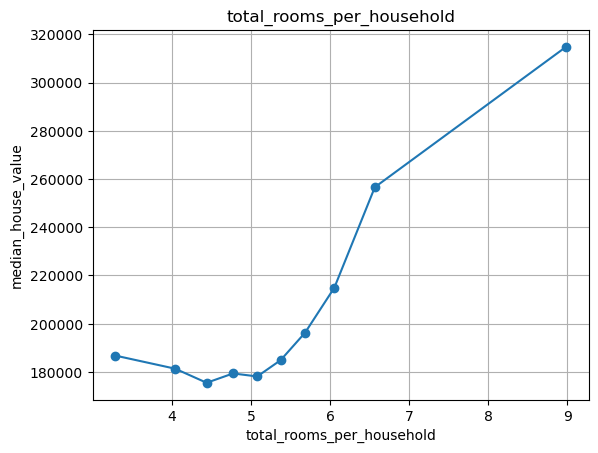

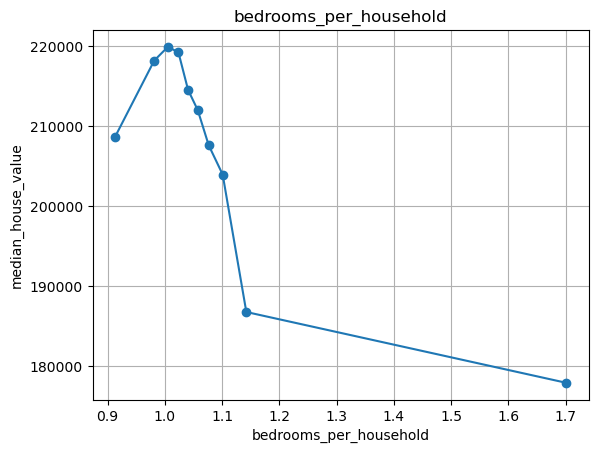

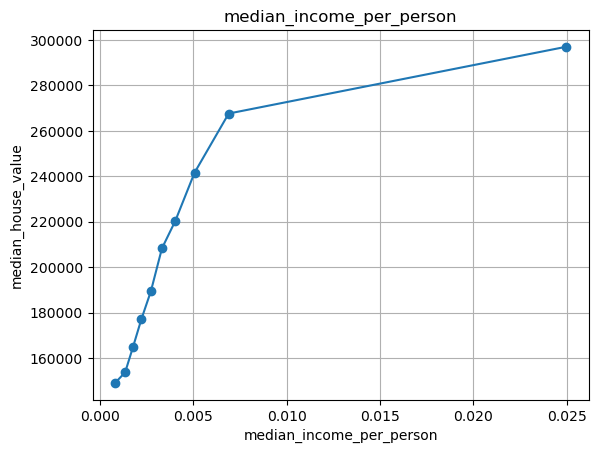

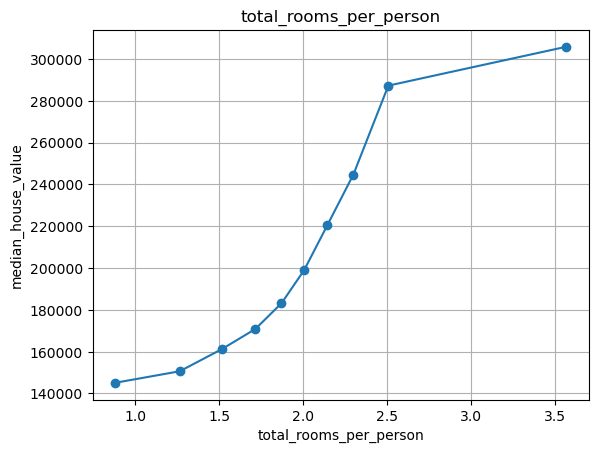

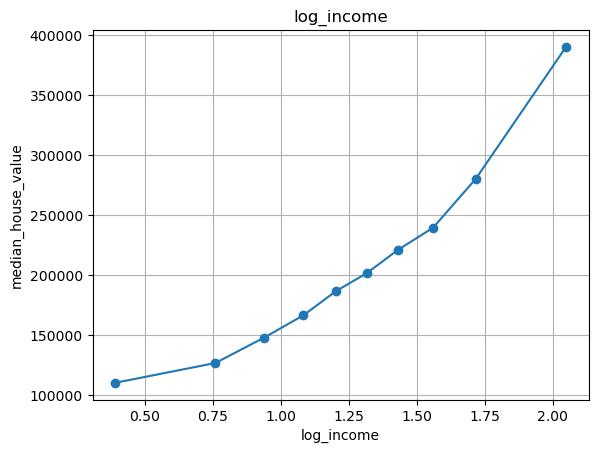

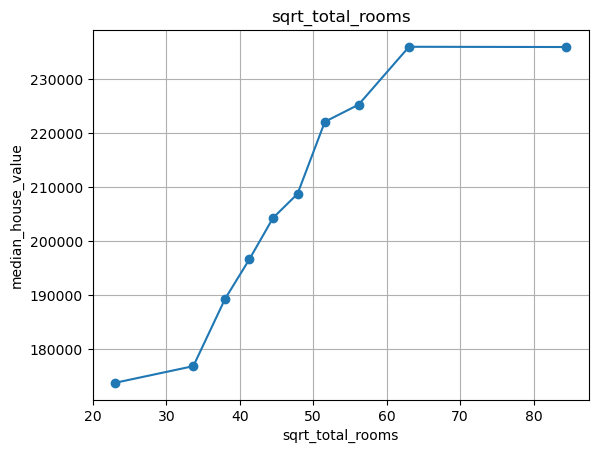

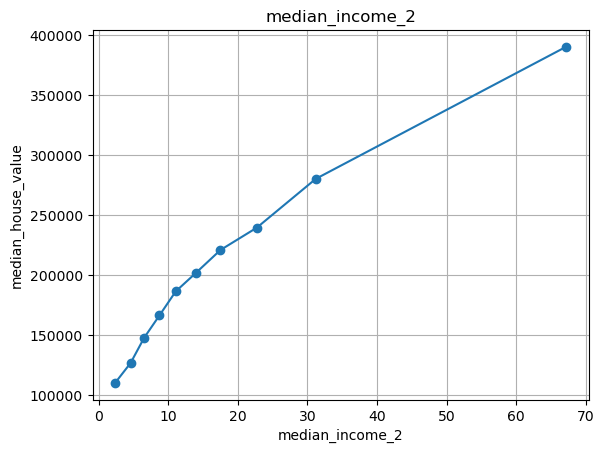

In [16]:
for i in numerical_features:
    if i !='median_house_value':
        flag_df=df[[target, i]]
        flag_df['bins']= pd.qcut(flag_df[i], q=10, labels=False)+1
        grouped = flag_df.groupby('bins').mean()
        plt.figure()
        plt.plot(grouped[i], grouped[target], marker='o')
        plt.grid()
        plt.xlabel(i)
        plt.ylabel(target)
        plt.title(i)
        plt.show()


### Regresion lineal feature eng

In [17]:
## vuelve a empezar
X=df.copy()
X=X.drop(target, axis=1)
# Dummies

# Crear dataset con las variables seleccionadas


# Manejo de valores nulos (rellenar con la mediana)

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Ridge o Lasso
model=linear_model.LinearRegression().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_lineal2 = model.predict(X_test)
r2_score(y_pred = predicciones_lineal2, y_true=y_test)

0.6671666919522781

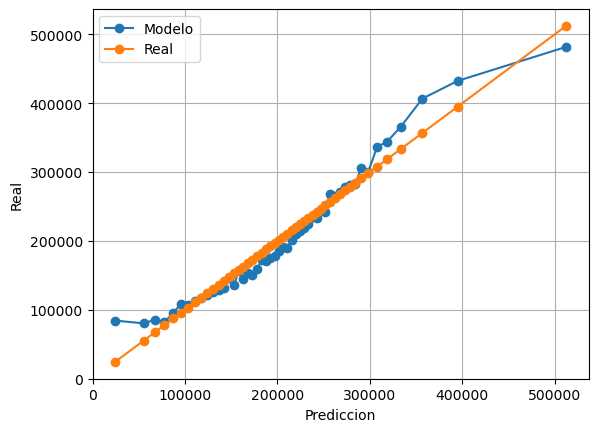

In [18]:
calibracion(predicciones_lineal, y_test, bins=50)

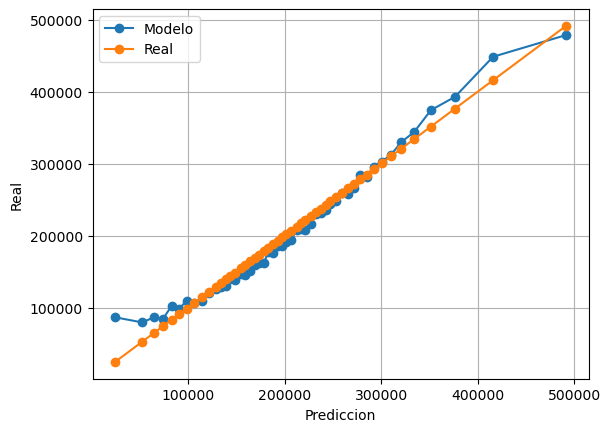

In [19]:
calibracion(predicciones_lineal2, y_test, bins=50)

### Regresion polinomial grado 2 feature eng 

In [26]:
degree = 2

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.3, random_state=42)

# Ridge o Lasso
model=linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly2_fe = model.predict(X_test)
r2_score(y_pred = predicciones_poly2_fe, y_true=y_test)


-55.976540580217254

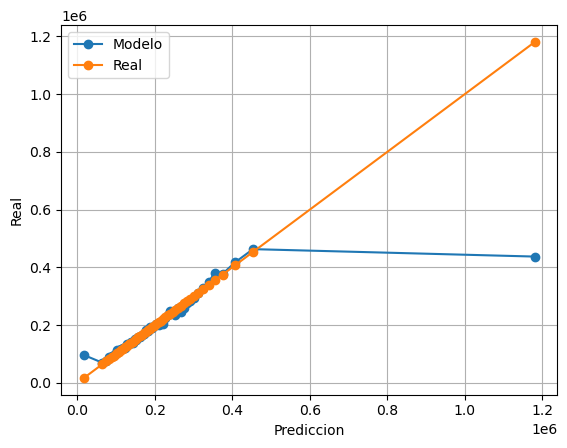

In [27]:
calibracion(predicciones_poly2_fe, y_test, bins=50)

### Regresion polinomial grado 3 feature eng 

In [28]:

degree = 3

# Aplicar StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Features polinomiales
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X_scaled)

# Crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.3, random_state=42)

# Ridge o Lasso
model=linear_model.Lasso().fit(X_train, y_train)

# Predicciones y r2, cuida el nombre de la prediccion 
predicciones_poly3_fe = model.predict(X_test)
r2_score(y_pred = predicciones_poly3_fe, y_true=y_test)


-17006.706505126014

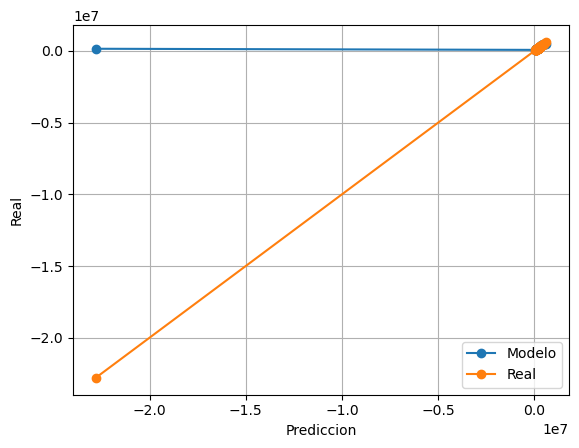

In [29]:
calibracion(predicciones_poly3_fe, y_test, bins=100)

### Transformar numericos a categoricos 

In [23]:
# Numericos ni ocean_proximity ni median_house_value
[i for i in df.keys( if i not in 'ocean_proximity' and i != 'median_house_value')]
# X = df.copy() y drop target


In [36]:
# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Crea funcion bins para las variables numericas 

def create_bins(X, numeric_vars, bins):
    for var in numeric_vars:
        X[f'{var}_bin'] = pd.qcut(X[var], q = bins, labels = False, duplicates = 'drop')
    return X

X_train = create_bins(X_train, numerical_features, 5)
X_test = create_bins(X_test, numerical_features, 5)


# Bin features
bin_features = [i for i in X_train.keys() if 'bin' in i]
ocean_features = [i for i in X_train.keys() if 'ocean_proximity' in i]

# Final features 
final_features = bin_features + ocean_features

# Apply get dummies to both pd.get_dummies(X_train[final_features], columns=bin_features, drop_first=True)
X_train = pd.get_dummies(X_train[final_features], columns=bin_features, drop_first = True)
X_test = pd.get_dummies(X_test[final_features], columns=bin_features, drop_first = True)

# Entrenar modelo con interacciones
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

predicciones_final = model.predict(X_test)
r2_score(y_pred=predicciones_final, y_true = y_test)


0.6612434594206753

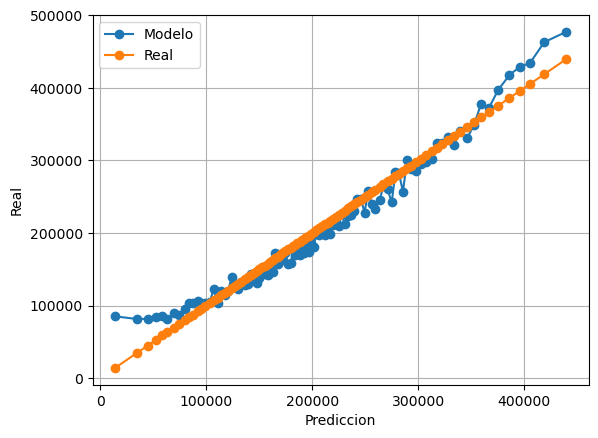

In [37]:
calibracion(predicciones_final, y_test, 100)

In [39]:
import lightgbm as lgb

model = lgb.LGBMRegressor().fit(X_train, y_train)
predicciones = model.predict(X_test)
r2_score(y_pred=predicciones, y_true=y_test)

calibracion(predicciones, y_test, 100)

ModuleNotFoundError: No module named 'lightgbm'